In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score
import nltk
import json
import string
from google.colab import drive

drive.mount('/content/drive')

MessageError: ignored

In [ ]:
%pip install sentence_transformers
# install sentence_transformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.6 MB/s 
     |████████████████████████████████| 5.8 MB 19.5 MB/s 
     |████████████████████████████████| 1.3 MB 44.4 MB/s 
     |████████████████████████████████| 182 kB 42.5 MB/s 
     |████████████████████████████████| 7.6 MB 42.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=48583d234c3cb1814ef134f41270d1f4740a5a8d4e29b6b94c4b85c3bdfc4e6f
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
# Please use data in same folder
df = pd.read_csv('~/sentences.csv', index_col=False)[['Original_txt','Label']]
# The manually labeled data
m, n = df.shape
df.index = np.arange(m)

In [ ]:
df

,Original_txt,Label
0,"writing – review & editing, #57221349415 , #...","[""Writing - Review and Editing""]"
1,#57201813576 G. and #56726810600 M. scientifi...,"[""Writing - Review and Editing""]"
2,"All authors discussed, edited, and approved th...","[""Writing - Review and Editing""]"
3,review & editing,"[""Writing - Review and Editing""]"
4,"writing – review & editing, #56486117100 , #...","[""Writing - Review and Editing""]"
...,...,...
501,"#35313098000 : Validation, Software","[""Software""]"
502,"and #57206485229 Writing – original draft, ...","[""Software""]"
503,"Software, #57191413427 M.Q. and #6701355516","[""Software""]"
504,Software #57033153900 Dongdong: Visualizatio...,"[""Software""]"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506 entries, 0 to 505
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Original_txt  506 non-null    object
 1   Label         506 non-null    object
dtypes: object(2)
memory usage: 11.9+ KB


In [ ]:
column_dic = {"Writing - Review and Editing":"Review", "Writing - Original Draft":"Draft",\
              "Funding acquisition":"Funding", "Visualization":"Visualization", "Software":"Software"}
# the mapping of labels to column names 

In [ ]:
# initialize all label columns
df_copy = df.copy()
df_copy["Stemmed"] = ""
df_copy["Label_list"] = ""

df_copy["Review"] = 0
df_copy["Draft"] = 0
df_copy["Funding"] = 0
df_copy["Visualization"] = 0
df_copy["Software"] = 0
# Assign labels
for i in range(m):
    df_copy["Label_list"][i] = eval(df_copy["Label"][i])
    for item in df_copy["Label_list"][i]:
        # Assign labels to different columns
        if column_dic.get(item, None)!= None:
            df_copy[column_dic[item]][i] = 1

<ipython-input-7-bca2c3c94c21>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy["Label_list"][i] = eval(df_copy["Label"][i])
<ipython-input-7-bca2c3c94c21>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy[column_dic[item]][i] = 1


In [ ]:
# Remove stop words with nltk
from nltk.corpus import stopwords
nltk.download("stopwords",quiet=True)
stop_words = set(stopwords.words('english'))
for i in range(m):
    sentence = df_copy['Original_txt'][i].split()
    # Use lower case words, remove words with only one letter, remove names(start with #) and finally remove all stop words
    df_copy['Stemmed'][i] = ' '.join([word.lower() for word in sentence if word not in stop_words and len(word)>1 and not word.startswith("#")])


<ipython-input-8-e43d7e6346de>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Stemmed'][i] = ' '.join([word.lower() for word in sentence if word not in stop_words and len(word)>1 and not word.startswith("#")])


In [ ]:
# Remove punctuations
import string
punctuations = string.punctuation

for i in range(m):
    sentence = df_copy['Stemmed'][i]
    # remove punctuations
    df_copy['Stemmed'][i] = sentence.translate(str.maketrans('', '', string.punctuation.replace('#','')))

<ipython-input-9-ea5c7dcdd40c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Stemmed'][i] = sentence.translate(str.maketrans('', '', string.punctuation.replace('#','')))


In [ ]:
# Lemma with Wordnet
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
# Use wordnet to lemmatize the words
lemmatizer = WordNetLemmatizer()
for i in range(m):
    sentence = df_copy['Stemmed'][i].split()
    df_copy['Stemmed'][i] = ' '.join([lemmatizer.lemmatize(word) for word in sentence if len(word)>1] )

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
<ipython-input-10-ccd999fc2337>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['Stemmed'][i] = ' '.join([lemmatizer.lemmatize(word) for word in sentence if len(word)>1] )


In [ ]:
df_copy
# Processed data

,Original_txt,Label,Stemmed,Label_list,Review,Draft,Funding,Visualization,Software
0,"writing – review & editing, #57221349415 , #...","[""Writing - Review and Editing""]",writing review editing,[Writing - Review and Editing],1,0,0,0,0
1,#57201813576 G. and #56726810600 M. scientifi...,"[""Writing - Review and Editing""]",scientifically supported reviewed paper,[Writing - Review and Editing],1,0,0,0,0
2,"All authors discussed, edited, and approved th...","[""Writing - Review and Editing""]",all author discussed edited approved final ver...,[Writing - Review and Editing],1,0,0,0,0
3,review & editing,"[""Writing - Review and Editing""]",review editing,[Writing - Review and Editing],1,0,0,0,0
4,"writing – review & editing, #56486117100 , #...","[""Writing - Review and Editing""]",writing review editing,[Writing - Review and Editing],1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
501,"#35313098000 : Validation, Software","[""Software""]",validation software,[Software],0,0,0,0,1
502,"and #57206485229 Writing – original draft, ...","[""Software""]",writing original draft software d resource sup...,[Software],0,0,0,0,1
503,"Software, #57191413427 M.Q. and #6701355516","[""Software""]",software mq,[Software],0,0,0,0,1
504,Software #57033153900 Dongdong: Visualizatio...,"[""Software""]",software dongdong visualization jiefeng zhiqia...,[Software],0,0,0,0,1


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
# Use sentence bert to encode sentences
sbert_embeddings = model.encode(df_copy['Stemmed'])
sbert_embeddings.shape

(506, 768)

# Logistic Regression

## Logistic regression model for label Review

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression


review_label = df_copy["Review"]
review_lr = LogisticRegression(random_state = 42, max_iter = 200)
# Stratified 5 fold cross-validate 
review_sbert_cv = cross_validate(review_lr, sbert_embeddings, review_label, cv=5,\
                    #scoring including f1, accuracy, roc_auc
                     scoring=('accuracy', 'f1', 'roc_auc'),\
                     groups = review_label,\
                     return_train_score=True)

# Predicted labels and predicted probs
review_sbert_label_pred = cross_val_predict(review_lr, sbert_embeddings, review_label, cv=5, groups = review_label)
review_sbert_label_pred_prob = cross_val_predict(review_lr, sbert_embeddings, review_label, cv=5, groups = review_label, method = 'predict_proba')

print('Sbert training on label review accuracy {}, f1-score {}, auc score {}'.format(np.mean(review_sbert_cv['train_accuracy']),\
                                                                     np.mean(review_sbert_cv['train_f1']),\
                                                                     np.mean(review_sbert_cv['train_roc_auc'])))
                                                                        
      
print('Sbert testing on label review accuracy {}, f1-score {}, auc score {}'.format(np.mean(review_sbert_cv['test_accuracy']),\
                                                                    np.mean(review_sbert_cv['test_f1']),\
                                                                    np.mean(review_sbert_cv['test_roc_auc'])))

Sbert training on label review accuracy 0.9950580613616916, f1-score 0.9874371069182389, auc score 0.9999114434947767
Sbert testing on label review accuracy 0.95055329062318, f1-score 0.8757797640724471, auc score 0.9845152062631737


## Logistic regression model for label Draft

In [ ]:
draft_label = df_copy["Draft"]
draft_lr = LogisticRegression(random_state = 42, max_iter = 200)
# Stratified 5 fold cross-validate 
draft_sbert_cv = cross_validate(draft_lr, sbert_embeddings, draft_label, cv=5,\
                     scoring=('accuracy', 'f1', 'roc_auc'),\
                     groups = draft_label,\
                     return_train_score=True)
# Predicted labels and predicted probs
draft_sbert_label_pred = cross_val_predict(draft_lr, sbert_embeddings, draft_label, cv=5, groups = draft_label)
draft_sbert_label_pred_prob = cross_val_predict(draft_lr, sbert_embeddings, draft_label, cv=5, groups = draft_label, method = 'predict_proba')

print('Sbert training on label review accuracy {}, f1-score {}, auc score {}'.format(np.mean(draft_sbert_cv['train_accuracy']),\
                                                                     np.mean(draft_sbert_cv['train_f1']),\
                                                                     np.mean(draft_sbert_cv['train_roc_auc'])))
                                                                        
      
print('Sbert testing on label review accuracy {}, f1-score {}, auc score {}'.format(np.mean(draft_sbert_cv['test_accuracy']),\
                                                                    np.mean(draft_sbert_cv['test_f1']),\
                                                                    np.mean(draft_sbert_cv['test_roc_auc'])))

Sbert training on label review accuracy 0.9920938760542721, f1-score 0.9847971525330015, auc score 0.9997826280307986
Sbert testing on label review accuracy 0.9268491555037857, f1-score 0.8463979979512715, auc score 0.9705067631734299


## Logistic regression model for label Funding

In [ ]:
funding_label = df_copy["Funding"]
funding_lr = LogisticRegression(random_state = 42, max_iter = 200)
# Stratified 5 fold cross-validate 
funding_sbert_cv = cross_validate(funding_lr, sbert_embeddings, funding_label, cv=5,\
                     scoring=('accuracy', 'f1', 'roc_auc'),\
                     groups = funding_label,\
                     return_train_score=True)
# Predicted labels and predicted probs
funding_sbert_label_pred = cross_val_predict(funding_lr, sbert_embeddings, funding_label, cv=5, groups = funding_label)
funding_sbert_label_pred_prob = cross_val_predict(funding_lr, sbert_embeddings, funding_label, cv=5,\
                                                  groups = funding_label, method = 'predict_proba')

print('Sbert training on label review accuracy {}, f1-score {}, auc score {}'.format(np.mean(funding_sbert_cv['train_accuracy']),\
                                                                     np.mean(funding_sbert_cv['train_f1']),\
                                                                     np.mean(funding_sbert_cv['train_roc_auc'])))
                                                                        
      
print('Sbert testing on label review accuracy {}, f1-score {}, auc score {}'.format(np.mean(funding_sbert_cv['test_accuracy']),\
                                                                    np.mean(funding_sbert_cv['test_f1']),\
                                                                    np.mean(funding_sbert_cv['test_roc_auc'])))

Sbert training on label review accuracy 0.992093876054272, f1-score 0.981203586110956, auc score 0.9997274597338937
Sbert testing on label review accuracy 0.9545525140749369, f1-score 0.8908950669926281, auc score 0.991866883116883


## Logistic regression model for label Visualization

In [ ]:
visualization_label = df_copy["Visualization"]
visualization_lr = LogisticRegression(random_state = 42, max_iter = 200)
# Stratified 5 fold cross-validate 
visualization_sbert_cv = cross_validate(visualization_lr, sbert_embeddings, visualization_label, cv=5,\
                     scoring=('accuracy', 'f1', 'roc_auc'),\
                     groups = visualization_label,\
                     return_train_score=True)
# Predicted labels and predicted probs
visualization_sbert_label_pred = cross_val_predict(visualization_lr, sbert_embeddings, visualization_label, cv=5, groups = visualization_label)
visualization_sbert_label_pred_prob = cross_val_predict(visualization_lr, sbert_embeddings,\
                                                        visualization_label, cv=5, groups = visualization_label, method = 'predict_proba')

print('Sbert training on label review accuracy {}, f1-score {}, auc score {}'.format(np.mean(visualization_sbert_cv['train_accuracy']),\
                                                                     np.mean(visualization_sbert_cv['train_f1']),\
                                                                     np.mean(visualization_sbert_cv['train_roc_auc'])))
                                                                        
      
print('Sbert testing on label review accuracy {}, f1-score {}, auc score {}'.format(np.mean(visualization_sbert_cv['test_accuracy']),\
                                                                    np.mean(visualization_sbert_cv['test_f1']),\
                                                                    np.mean(visualization_sbert_cv['test_roc_auc'])))

Sbert training on label review accuracy 0.9930815303752597, f1-score 0.9833891026559083, auc score 0.9997528011204482
Sbert testing on label review accuracy 0.8794214715589206, f1-score 0.7185588694544658, auc score 0.885064935064935


## Logistic regression model for label Software

In [ ]:
software_label = df_copy["Software"]
software_lr = LogisticRegression(random_state = 42, max_iter = 200)
# Stratified 5 fold cross-validate 
software_sbert_cv = cross_validate(software_lr, sbert_embeddings, software_label, cv=5,\
                     scoring=('accuracy', 'f1', 'roc_auc'),\
                     groups = software_label,\
                     return_train_score=True)
# Predicted labels and predicted probs
software_sbert_label_pred = cross_val_predict(software_lr, sbert_embeddings, software_label, cv=5, groups = software_label)
software_sbert_label_pred_prob = cross_val_predict(software_lr, sbert_embeddings,\
                                                        software_label, cv=5, groups = software_label, method = 'predict_proba')

print('Sbert training on label review accuracy {}, f1-score {}, auc score {}'.format(np.mean(software_sbert_cv['train_accuracy']),\
                                                                     np.mean(software_sbert_cv['train_f1']),\
                                                                     np.mean(software_sbert_cv['train_roc_auc'])))
                                                                        
      
print('Sbert testing on label review accuracy {}, f1-score {}, auc score {}'.format(np.mean(software_sbert_cv['test_accuracy']),\
                                                                    np.mean(software_sbert_cv['test_f1']),\
                                                                    np.mean(software_sbert_cv['test_roc_auc'])))

Sbert training on label review accuracy 0.9985185185185184, f1-score 0.9967798814857638, auc score 0.9999897122764718
Sbert testing on label review accuracy 0.9347893612890701, f1-score 0.8684094540621603, auc score 0.975585404933231


## Overall Performance

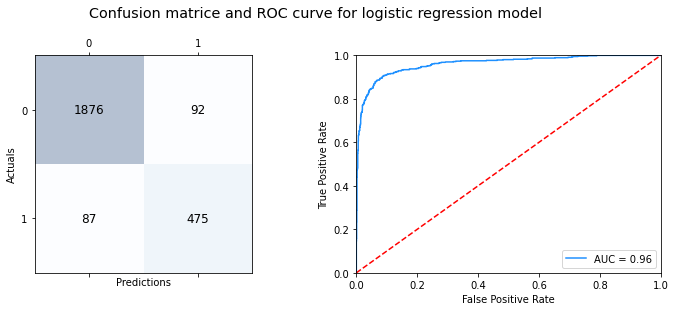

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# All predicted labels
sbert_label_pred = np.concatenate([review_sbert_label_pred, draft_sbert_label_pred, funding_sbert_label_pred,\
                                   visualization_sbert_label_pred,software_sbert_label_pred])
# All predicted probs
tmp_prob= np.concatenate([review_sbert_label_pred_prob, draft_sbert_label_pred_prob,\
                                        funding_sbert_label_pred_prob, visualization_sbert_label_pred_prob, software_sbert_label_pred_prob])
sbert_label_pred_prob = []
for i in range(len(sbert_label_pred)):
    sbert_label_pred_prob.append(tmp_prob[i, sbert_label_pred[i]])
sbert_label_pred_prob = np.array(sbert_label_pred_prob)

# True labels
sbert_label = np.concatenate([review_label, draft_label, funding_label, visualization_label, software_label])

# Print confusion matrix
sbert_conf_matrix = confusion_matrix(sbert_label_pred, sbert_label)

fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

ax[0].matshow(sbert_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(sbert_conf_matrix.shape[0]):
    for j in range(sbert_conf_matrix.shape[1]):
        ax[0].text(x=i, y=j,s=sbert_conf_matrix[i, j], va='center', ha='center', size='large')
 

ax[0].set_xlabel('Predictions', fontsize=10)
ax[0].set_ylabel('Actuals', fontsize=10)

# Print ROC curve
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(sbert_label, tmp_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)
ax[1].plot(fpr, tpr, 'dodgerblue', label = 'AUC = %0.2f' % roc_auc)
ax[1].legend(loc = 'lower right')
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')


st = fig.suptitle("Confusion matrice and ROC curve for logistic regression model", fontsize="x-large")
st.set_y(1.05)
plt.savefig('/content/drive/MyDrive/ENGI 4800/data/logistic_conf_roc.jpg', bbox_inches = 'tight')

In [ ]:
# Accuracy
acc = (1876+475)/(1876+475+92+87)
acc

0.9292490118577075

## Single Layer Perceptron

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Flatten, Embedding, Dense

In [ ]:
from sklearn.model_selection import KFold

inputs, targets = sbert_embeddings, labels
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True, random_state = 2511)

lab = []
predict_lab = []
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
  # Define the model architecture
    model = Sequential()
    model.add(Dense(units = 5, activation = 'sigmoid'))

    model.compile(keras.optimizers.Adam(lr=0.001), loss="mse",\
             metrics=[tf.keras.metrics.CategoricalAccuracy()])  


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=80,
              epochs=30,
              verbose=0)
    lab.append(targets[test])
    predict_lab.append(model.predict(inputs[test]))

    # Increase fold number
    fold_no = fold_no + 1

NameError: ignored

In [ ]:
lab_concat = np.squeeze(np.concatenate(lab).reshape([m*5, 1]))
predict_lab_concat = np.squeeze(np.concatenate(predict_lab).reshape([m*5, 1]))

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Predicted labels, use 0.5 as threshold
nn_sbert_label_pred = 1*(predict_lab_concat>0.5)

# Predicted probs
nn_sbert_label_pred_prob = predict_lab_concat

# True labels 
nn_sbert_label = lab_concat

# Confusion matrix
nn_sbert_conf_matrix = confusion_matrix(nn_sbert_label_pred, nn_sbert_label)

fig, ax = plt.subplots(ncols = 2, figsize=(12,4))

ax[0].matshow(nn_sbert_conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(nn_sbert_conf_matrix.shape[0]):
    for j in range(nn_sbert_conf_matrix.shape[1]):
        ax[0].text(x=i, y=j,s=nn_sbert_conf_matrix[i, j], va='center', ha='center', size='large')
 

ax[0].set_xlabel('Predictions', fontsize=10)
ax[0].set_ylabel('Actuals', fontsize=10)

import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(nn_sbert_label, nn_sbert_label_pred_prob)
roc_auc = metrics.auc(fpr, tpr)
ax[1].plot(fpr, tpr, 'dodgerblue', label = 'AUC = %0.2f' % roc_auc)
ax[1].legend(loc = 'lower right')
ax[1].plot([0, 1], [0, 1],'r--')
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_ylabel('True Positive Rate')
ax[1].set_xlabel('False Positive Rate')


st = fig.suptitle("Confusion matrice and ROC curve for Neural Network model", fontsize="x-large")
st.set_y(1.05)
plt.savefig('/content/drive/MyDrive/ENGI 4800/data/nn_conf_roc.jpg', bbox_inches = 'tight')